<a href="https://colab.research.google.com/github/RicParpa/JetFlavor/blob/main/JetFlavor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==1.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 21.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
!rm -rf dataset.json
!rm -rf dataset.json.gz
!wget http://mlphysics.ics.uci.edu/data/hb_jet_flavor_2016/dataset.json.gz


--2022-12-16 17:19:31--  http://mlphysics.ics.uci.edu/data/hb_jet_flavor_2016/dataset.json.gz
Resolving mlphysics.ics.uci.edu (mlphysics.ics.uci.edu)... 128.195.1.86
Connecting to mlphysics.ics.uci.edu (mlphysics.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2386808363 (2.2G) [application/x-gzip]
Saving to: ‘dataset.json.gz’

dataset.json.gz     100%[===================>]   2.22G  15.2MB/s    in 2m 21s  

2022-12-16 17:21:52 (16.1 MB/s) - ‘dataset.json.gz’ saved [2386808363/2386808363]



In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
from tensorflow.keras import layers

Leggiamo le prime 5 colonne del dataset 500000 righe alla volta e le uniamo in un dataframe di 2 milioni di righe (eventi).

In [ ]:
chunks = pd.read_json('dataset.json.gz', lines = True, chunksize=500000)

def concatenatore (ck):
  i=0
  tensor=[]
  for k in ck:
    if i>3:
      break
    k.drop(k.columns[[5]], axis = 1, inplace = True)
    tensor.append(k)
    i = i+1
  return tensor;

tensor = concatenatore(chunks)
tensor = pd.concat(tensor)

df = tensor
print(df)

               0         1  2  \
0        47.8712  1.893250  5   
1        34.9703  0.609755  5   
2        26.5706 -0.530268  5   
3        36.9246 -2.074420  5   
4        28.9667  1.512090  5   
...          ...       ... ..   
1999995  35.1177  0.252782  5   
1999996  34.8303 -0.808358  5   
1999997  29.4848 -0.840796  5   
1999998  25.7466 -0.865773  5   
1999999  28.9731 -2.326480  5   

                                                         3  \
0        [21.1765, 8.36586, 29.0269, 4.149, 5, 2.68624e...   
1        [5.0077, 3.03583, 2.00754, 0.32992099999999996...   
2        [0.8078839999999999, 0.6305649999999999, 1.044...   
3        [16.5617, 10.357, 17.5166, 30.4992, 4, 4.35319...   
4        [18.0325, 16.1445, 3.29359, 9.00347, 4, 3.3143...   
...                                                    ...   
1999995  [2.11239, 1.33285, 0.441166, 0.217754, 2, 0.00...   
1999996  [0.824012, 0.41628000000000004, 1.37785, 0.760...   
1999997  [1.45084, 1.2525, 0.770663, 1.96815,

Dividiamo il dataset in eventi di classe 1 (flavor = 5) ed eventi di classe 2 (flavor = 0 e flavor = 4). Poiché le due configurazioni sono molto sbilanciate, tagliamo la classe più numerosa allo stesso numero di eventi di quella meno numerosa.


In [ ]:
cond1 = df[2] == 5
dataset_classe1 = df[cond1].values
#dataset_classe1

cond2 = df[2] != 5
dataset_classe2 = df[cond2].values
#dataset_classe2

print(dataset_classe1.shape, dataset_classe2.shape)
print(len(dataset_classe2))

dataset_classe1 = dataset_classe1[0:len(dataset_classe2)][:]
print(dataset_classe1.shape)

(1828750, 5) (171250, 5)
171250
(171250, 5)


Uniamo i dataset delle due classi e mescoliamo le righe in maniera casuale in modo da avere un dataset omogeneo.

In [ ]:
dataset = np.concatenate((dataset_classe1,dataset_classe2), axis = 0)
print(dataset.shape)
np.random.shuffle(dataset)
np.random.seed(1234)
print(dataset)

(342500, 5)
[[24.8372 2.14779 5
  list([40.0829, 38.9911, 42.8764, 17.6421, 4, 3.44542e-17, 0.144208, 0.252595])
  list([76.4005, 1, 2, 0.38647299999999996, 0.319795, 0.18357199999999999])]
 [24.4613 1.8719800000000002 0
  list([0.9655239999999999, '-inf', 0.542345, '-inf', 0, 0.10756099999999999, 0.0294951, 0.0981485])
  list([-1, -1, -1, 'inf', -1, '-inf'])]
 [28.2742 -1.06965 5
  list([21.8931, 13.5264, 3.95583, 2.00677, 6, 1.0714600000000003e-15, 0.095354, 0.138671])
  list([88.4217, 2, 5, 0.113212, 1.98228, 0.6210519999999999])]
 ...
 [25.7177 0.421292 5
  list([4.02657, 0.136679, 0.0224637, 0.47055, 2, 0.0007335340000000001, 0.165536, 0.10527])
  list([-1, -1, -1, 'inf', -1, '-inf'])]
 [33.7001 -0.44517799999999996 5
  list([1.50458, '-inf', 1.53197, '-inf', 1, 0.000434408, 0.106206, 0.0702319])
  list([35.2886, 1, 2, 0.11746000000000001, 1.42181, 0.973598])]
 [26.0728 -2.4862 0
  list(['-inf', '-inf', '-inf', '-inf', 0, 0.057028699999999995, 0.177813, 0.143865])
  list([-1, -1, 

Adesso creiamo l'array con le labels del nuovo dataset bilanciato.

In [ ]:
labels = np.zeros(len(dataset))
classe1 = 0
classe2 = 0
for i in range(len(dataset)):
  if dataset[i][2]==5:
    labels[i]=1
    classe1 += 1
  else:
    labels[i]=0
    classe2 += 1
print(labels.shape)

print(classe1, classe2)

(342500,)
171250 171250


Eliminiamo la terza colonna del dataset, che contiene i flavor (usati per le labels).

In [ ]:
data = np.delete(dataset, 2, 1)
print(data.shape)
print(data)


(342500, 4)
[[24.8372 2.14779
  list([40.0829, 38.9911, 42.8764, 17.6421, 4, 3.44542e-17, 0.144208, 0.252595])
  list([76.4005, 1, 2, 0.38647299999999996, 0.319795, 0.18357199999999999])]
 [24.4613 1.8719800000000002
  list([0.9655239999999999, '-inf', 0.542345, '-inf', 0, 0.10756099999999999, 0.0294951, 0.0981485])
  list([-1, -1, -1, 'inf', -1, '-inf'])]
 [28.2742 -1.06965
  list([21.8931, 13.5264, 3.95583, 2.00677, 6, 1.0714600000000003e-15, 0.095354, 0.138671])
  list([88.4217, 2, 5, 0.113212, 1.98228, 0.6210519999999999])]
 ...
 [25.7177 0.421292
  list([4.02657, 0.136679, 0.0224637, 0.47055, 2, 0.0007335340000000001, 0.165536, 0.10527])
  list([-1, -1, -1, 'inf', -1, '-inf'])]
 [33.7001 -0.44517799999999996
  list([1.50458, '-inf', 1.53197, '-inf', 1, 0.000434408, 0.106206, 0.0702319])
  list([35.2886, 1, 2, 0.11746000000000001, 1.42181, 0.973598])]
 [26.0728 -2.4862
  list(['-inf', '-inf', '-inf', '-inf', 0, 0.057028699999999995, 0.177813, 0.143865])
  list([-1, -1, -1, 'inf', -

Scriviamo il nuovo dataframe estrapolando le variabili di tracking e vertex.

In [ ]:
nrighe = len((data))
print(nrighe)

tracking_variables = np.zeros((nrighe,8))
for j in range(8):
  for i in range(nrighe):
    tracking_variables[i][j] = data[i][2][j]
print(tracking_variables.shape)

vertex_variables = np.zeros((nrighe,6))
for j in range(6):
  for i in range(nrighe):
    vertex_variables[i][j] = data[i][3][j]
print(vertex_variables.shape)

prime_due_colonne= np.zeros((nrighe,2))
for j in range(2):
  for i in range(nrighe):
    prime_due_colonne[i][j]=data[i][j]

high_level_variables = np.concatenate((tracking_variables, vertex_variables), axis=1)
print(high_level_variables.shape)
data_completo=np.concatenate((prime_due_colonne, high_level_variables), axis=1)
print(data_completo.shape)


df= pd.DataFrame(data_completo)
print(df)

342500
(342500, 8)
(342500, 6)
(342500, 14)
(342500, 16)
             0         1          2          3          4          5    6   \
0       24.8372  2.147790  40.082900  38.991100  42.876400  17.642100  4.0   
1       24.4613  1.871980   0.965524       -inf   0.542345       -inf  0.0   
2       28.2742 -1.069650  21.893100  13.526400   3.955830   2.006770  6.0   
3       39.1396  1.652650  10.191400  16.124900   1.771140  14.301600  5.0   
4       37.1912  0.540546   3.581540   3.022570   1.593930   0.028418  5.0   
...         ...       ...        ...        ...        ...        ...  ...   
342495  36.6842 -0.094224   1.282910   0.588207   0.862186   0.660734  1.0   
342496  36.2943 -1.144770   9.067270       -inf   1.607130       -inf  2.0   
342497  25.7177  0.421292   4.026570   0.136679   0.022464   0.470550  2.0   
342498  33.7001 -0.445178   1.504580       -inf   1.531970       -inf  1.0   
342499  26.0728 -2.486200       -inf       -inf       -inf       -inf  0.0   

      

Normalizzazione dataframe


In [ ]:
#sostituiamo i +inf e -inf con dei NaN, che vengono ignorati nel calcolo della media.
df = df.applymap(lambda x: np.nan if x == np.inf  else x)
df = df.applymap(lambda x: np.nan if x == np.NINF  else x)

train_to_rest_ratio=0.8
vali_to_test_ratio=0.5

#calcoliamo i parametri per la normalizzazione solo con il training set
n_time_steps=int(len(data)*train_to_rest_ratio)
data_mean = df.iloc[:n_time_steps].mean()
data_std = df.iloc[:n_time_steps].std()


df = (df - data_mean)/data_std
df = pd.DataFrame(df)
#sostituiamo i NaN con 0.
df =df.fillna(0)

#split dei dati
n_time_steps_2 = int(len(data)*(1-train_to_rest_ratio)*vali_to_test_ratio)
train_data = df.iloc[:n_time_steps]
test_data = df.iloc[(n_time_steps):]


train_labels = labels[:n_time_steps]
test_labels = labels[n_time_steps:]

display(train_data)
display(test_data)

X_train=np.array(train_data)
X_test=np.array(test_data)

print(train_labels.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.678880,1.551626,4.532298,6.870447,2.068997,1.301436,1.461494,-0.241201,0.911836,2.704066,0.317607,0.715920,0.208219,-0.069210,0.075666,-1.352884
1,-0.710477,1.352423,-0.472327,0.000000,-0.197927,0.000000,-0.885043,0.704568,-1.455366,-0.223216,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
2,-0.389977,-0.772161,2.205119,2.021459,-0.015140,-0.080786,2.634763,-0.241201,-0.096309,0.544822,0.437781,1.478446,1.093957,-0.347008,1.069886,-0.352136
3,0.523331,1.194012,0.708019,2.516266,-0.132127,1.006123,2.048128,-0.241201,-0.633144,-0.101999,1.236815,1.478446,1.684450,-0.356602,1.625010,0.871069
4,0.359555,0.390799,-0.137637,0.021320,-0.141617,-0.255680,2.048128,-0.241197,-0.248474,-1.023190,0.274475,1.478446,1.684450,-0.372649,1.756051,-0.144165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273995,0.057742,0.564079,-0.506472,-0.530670,-0.132413,-0.246187,-0.298408,-0.146219,-0.066744,-0.426762,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
273996,-0.725103,-0.190378,-0.529629,0.000000,-0.213295,0.000000,-0.298408,-0.210692,-0.744718,2.230288,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
273997,1.219101,-0.514269,-0.225485,-0.176083,-0.211333,-0.226565,0.874860,-0.241173,-0.168781,1.055767,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
273998,1.649841,1.036541,-0.431090,-0.335674,-0.138261,-0.169800,-0.298408,-0.207085,-0.331410,0.084938,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
274000,0.031054,0.398260,-0.533686,0.000000,-0.164028,0.000000,-0.298408,-0.211806,2.285484,-0.681381,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
274001,-0.424903,0.520999,0.004029,0.288963,-0.138903,-0.112782,2.048128,-0.241201,-0.282026,-0.009734,0.259305,1.478446,1.979696,-0.370612,2.699496,2.131932
274002,-0.689034,-0.101573,-0.561707,0.000000,-0.204871,0.000000,-0.298408,-0.224833,-0.611561,0.451970,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
274003,-0.416413,-0.078225,-0.491004,-0.430832,-0.173014,-0.217986,-0.298408,-0.129419,2.317676,0.703974,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
274004,-0.514364,0.997128,-0.555863,-0.515564,-0.170809,-0.123824,-0.298408,0.155100,-1.776560,-0.018889,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342495,0.316939,-0.067662,-0.431721,-0.442231,-0.180800,-0.199781,-0.298408,-0.208065,-0.347518,0.156828,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
342496,0.284165,-0.826416,0.564200,0.000000,-0.140910,0.000000,0.288226,-0.241195,-1.471741,2.860469,-0.310747,0.715920,0.208219,-0.336980,0.203657,0.514634
342497,-0.604868,0.304668,-0.080701,-0.528211,-0.225766,-0.216594,0.288226,-0.234751,1.351958,-0.088239,-0.456157,-0.809132,-0.677520,0.000000,-0.713615,0.000000
342498,0.066105,-0.321138,-0.403361,0.000000,-0.144934,0.000000,-0.298408,-0.237382,0.127631,-0.752329,-0.093384,0.715920,0.208219,-0.342689,0.734707,0.454323


(274000,)


In [ ]:
#applichiamo alle labels il one_hot encoding
# N.B. runnare solo 1 volta

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

print(train_labels.shape)
print(train_labels[1000])

(274000, 2)
[1. 0.]


In [ ]:
#definiamo il modello
keras.backend.clear_session()
model = keras.Sequential([
                          keras.layers.Dense(64, activation='relu'),
                          keras.layers.Dense(32, activation='relu'),
                          keras.layers.Dense(16, activation='relu'),
                          keras.layers.Dense(8, activation='relu'),
                          keras.layers.Dense(2, activation='softmax'),
])

In [ ]:
#compiliamo il modello

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [ ]:
print(X_train.shape)
print(train_labels.shape)

(274000, 16)
(274000, 2)


In [ ]:
#applichiamo il modello ai dati

history = model.fit(X_train, train_labels, epochs=100, batch_size=100,
                    validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/100
2192/2192 [==============================] - 8s 3ms/step - loss: 0.4133 - auc: 0.8948 - val_loss: 0.3647 - val_auc: 0.9163
Epoch 2/100
2192/2192 [==============================] - 3s 1ms/step - loss: 0.3620 - auc: 0.9171 - val_loss: 0.3605 - val_auc: 0.9180
Epoch 3/100
2192/2192 [==============================] - 3s 1ms/step - loss: 0.3589 - auc: 0.9184 - val_loss: 0.3582 - val_auc: 0.9191
Epoch 4/100
2192/2192 [==============================] - 3s 2ms/step - loss: 0.3568 - auc: 0.9194 - val_loss: 0.3568 - val_auc: 0.9196
Epoch 5/100
2192/2192 [==============================] - 3s 2ms/step - loss: 0.3552 - auc: 0.9201 - val_loss: 0.3552 - val_auc: 0.9203
Epoch 6/100
2192/2192 [==============================] - 4s 2ms/step - loss: 0.3538 - auc: 0.9207 - val_loss: 0.3542 - val_auc: 0.9206
Epoch 7/100
2192/2192 [==============================] - 3s 2ms/step - loss: 0.3525 - auc: 0.9212 - val_loss: 0.3528 - val_auc: 0.9212
Epoch 8/100
2192/2192 [==============================] 

Calcoliamo la loss e l'accuracy sul test sample

In [ ]:
test_loss, test_auc = model.evaluate(X_test, test_labels, verbose=2)
print('Test AUC:', test_auc)

2141/2141 - 2s - loss: 0.3287 - auc: 0.9305 - 2s/epoch - 1ms/step
Test AUC: 0.9304797053337097


In [ ]:
#riassunto del modello
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 2)                 18        
                                                                 
Total params: 3,850
Trainable params: 3,850
Non-trainable params: 0
_________________________________________________________________


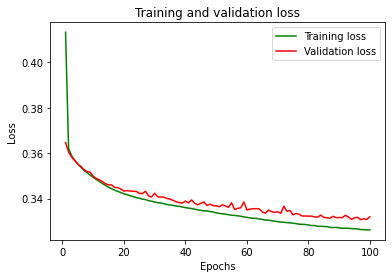

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot traing e validation loss
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('val.jpeg')

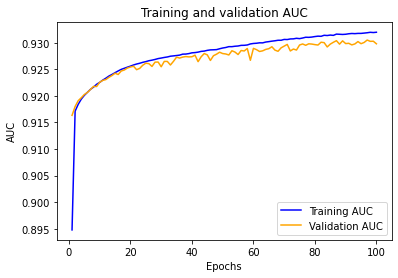

In [ ]:
#plotting trainig e validation AUC

acc_values = history_dict['auc']
val_acc_values = history_dict['val_auc']

plt.clf()
plt.plot(epochs, acc_values, 'b', label='Training AUC')
plt.plot(epochs, val_acc_values, 'orange', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

Utilizziamo la rete allenata per fare predizioni sul test set

In [ ]:
predictions = model.predict(X_test)
n_test=0

print(predictions[n_test])
print('Max probability for number:', np.argmax(predictions[n_test]))
print(test_labels[n_test])
print('True label is:',np.argmax(test_labels[n_test]))

2141/2141 [==============================] - 2s 941us/step
[0.16410357 0.83589643]
Max probability for number: 1
[0. 1.]
True label is: 1
